# Exploratory data analysis (EDA) of regulated banks

![](fdic_hq.jpeg)

Outline:
1. Business context - although costly, failed banks do not fully explain decrease in number of banks
    * Costs of failed banks from FDIC website
    * Web scraping details of failed banks
    * API client total number of banks
2. Historical events database - Commercial vs Savings banks
    * De novo banks (*newly established institutions with no existing. operations and new institutions that result from the conversion of an operating, non-insured entity -- they can't fail during the first 5 years*)
    * Mergers, acquisitions, branch sales and conversions...
        - More than 2 banks merging into 1 entity
        - Several banks acquired by 1 bank
        - Branch sales to do change Certificate IDs
        - But conversions sometimes do change IDs
    * Voluntary liquidation, charter changes and transfers
        - check with Cullan
    * Failures, paid offs vs assistance
        - check
3. Waterfall chart as an interactive tool 
    * Commercial banks consolidation 
    * Savings banks consolidation 
    * Industry as a whole 
4. Local GUI for customized querying 
    * Inputed years outside the range
    * Example of a successful query 
    * Data download functionality 

## 1. FDIC insurance
is required for most of US credit institutions including commercial banks and savings institutions...

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### 1.1 Costs of failed banks
The dataset was retrieved on 10/22/2021 using download functionality. It contains information about recently (last 20 years) failed banks, i.e. name of the bank and IDs, date of restructuring and costs. Source: https://www.fdic.gov/resources/resolutions/bank-failures/failed-bank-list/

#### 1.1.1 Imputing missing values of COSTS
The data set had several issues that required data cleaning and transformation. First, loading the dataset, dropping unused columns and checking missing values.

In [132]:
costs = pd.read_csv('../../data/failed_banks.csv', index_col=0)
costs.drop(['FIN', 'ID', 'RESTYPE1', 'SAVR' ], axis=1, inplace=True)
costs.isnull().sum().sum()

14

It appears that 14 failed banks have NaN for restructuring costs. These missing values can be imputed either with zeros, or column average, or, even better, average % of costs to assets, as restructuring a bigger bank is more expensive. Need to check how these missing values related to the type pf resolution, RESTYPE. As shown below, there are 2 types - ASSISTANCE and FAILURE

In [133]:
costs.groupby([costs['RESTYPE']]).count()

,CHCLASS1,CITYST,COST,FAILDATE,NAME,QBFASSET,QBFDEP
RESTYPE,,,,,,,
ASSISTANCE,13,13,0,13,13,13,13
FAILURE,564,564,563,564,564,564,564


Comparing groupings with missing values. It appears that all 13 ASSISTANCE cases have NaN for COST and thus it is warranted to impute these values with zeros. In other words, assistance is not a failure and there are no direct costs associated with bank's restructuring in this case. There is only one ("NET FIRST NATIONAL BANK") missing value in case of an actual FAILURE and it should probably be imputed with some kind of proxy for COST.

In [134]:
missing_data = costs[costs.isnull().any(axis=1)]
missing_data.groupby([missing_data['RESTYPE']]).count()

,CHCLASS1,CITYST,COST,FAILDATE,NAME,QBFASSET,QBFDEP
RESTYPE,,,,,,,
ASSISTANCE,13,13,0,13,13,13,13
FAILURE,1,1,0,1,1,1,1


Using relative costs seems warranted in this case - need to compute mean of COST / QBFASSET and apply it to the bank's assets to estimate possible restructuring costs. The overall average is around 23%.

In [135]:
avg_CostsToAssets  = np.round(np.mean(costs['COST']/costs['QBFASSET']), 2)
avg_CostsToAssets

0.23

After the COST value was imputed with the multiplier `avg_CostsToAssets`:

In [136]:
costs.iloc[561, 2] = costs.iloc[561, 6] * avg_CostsToAssets
costs.iloc[561, ]

CHCLASS1                          N
CITYST               BOCA RATON, FL
COST                     7268.23000
FAILDATE                 03/01/2002
NAME        NET FIRST NATIONAL BANK
QBFASSET                      37207
QBFDEP                        31601
RESTYPE                     FAILURE
Name: 26652, dtype: object

After this imputation all remaining 13 missing values are associated with assistance RESTYPE and thus should have zero COST, i.e. one can impute these missing values with zeros.

In [137]:
costs[costs.isnull().any(axis=1)].groupby("RESTYPE").count()

,CHCLASS1,CITYST,COST,FAILDATE,NAME,QBFASSET,QBFDEP
RESTYPE,,,,,,,
ASSISTANCE,13,13,0,13,13,13,13


In [138]:
costs['COST'].replace(np.nan, 0, inplace=True)

The resulting DataFrame `costs` does not have any missing values.

In [139]:
costs.isnull().sum().sum()

0

#### 1.1.2 Converting and splitting FAILDATE
Column FAILDATE has information about when the bank has failed, it needs to be converted to `datetime` object and preferably split into for time series analysis.

In [141]:
costs['DATE'] = pd.to_datetime(costs['FAILDATE'])
costs.drop('FAILDATE', axis=1, inplace=True)

Split the DATE column so that information about the year and month of failure are stored in separate columns. 

In [143]:
costs['YEAR_FAILED'] = costs['DATE'].dt.year.astype('Int64')
costs['MONTH_FAILED'] = costs['DATE'].dt.month.astype('Int64')
costs['QUARTER_FAILED'] = pd.PeriodIndex(costs.DATE, freq='Q')

#### 1.1.3 Plotting distributions and cumsum of COSTS

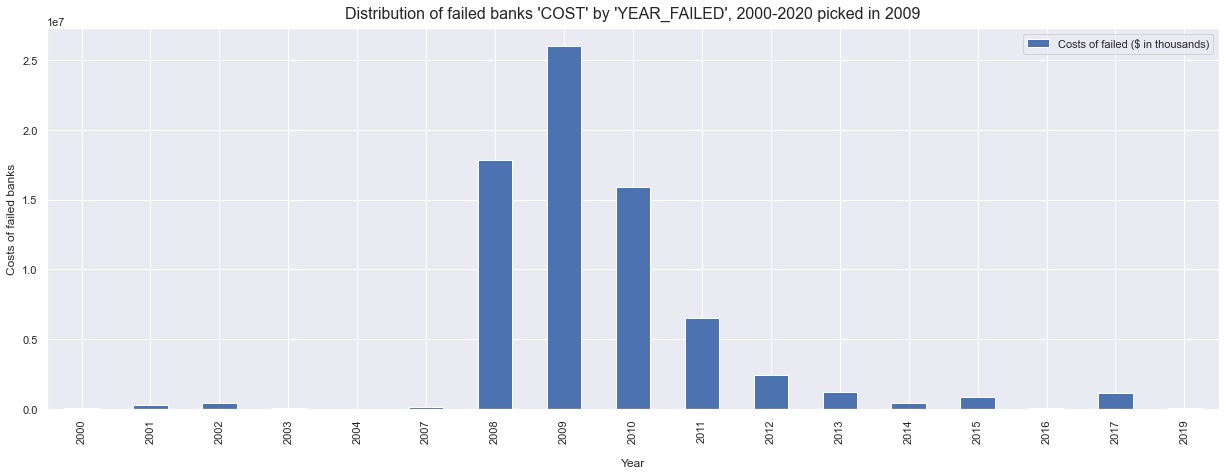

In [145]:
costs.groupby(['YEAR_FAILED'])['COST'].sum().plot(kind='bar',
                                               figsize=(21, 7),
                                               label='Costs of failed ($ in thousands)')
plt.title("Distribution of failed banks 'COST' by 'YEAR_FAILED' (2000-2020) picked in 2009", y=1.01, fontsize=16)
plt.ylabel("Costs of failed banks", labelpad=5)
plt.xlabel("Year", labelpad=15)
plt.legend()
plt.show()

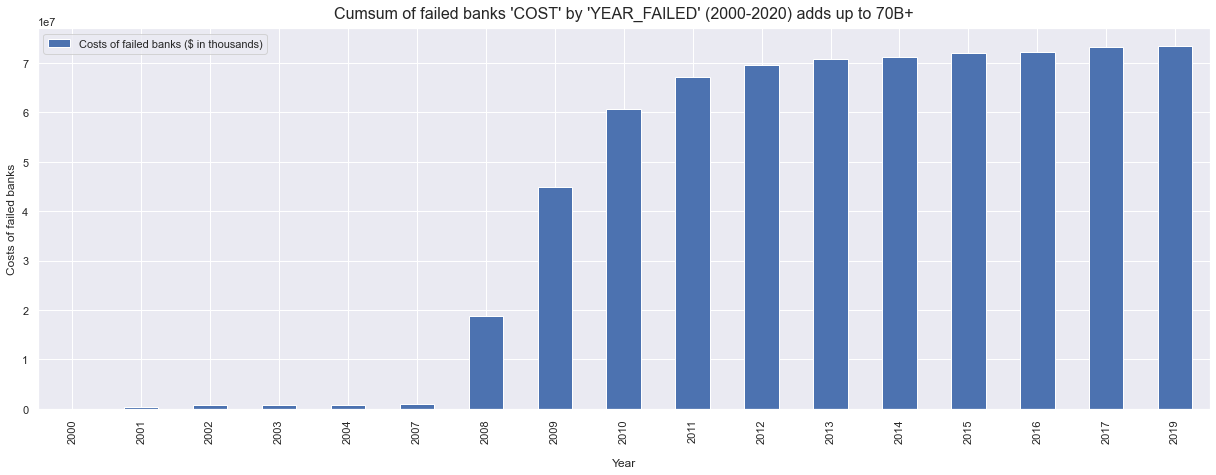

In [146]:
costs.groupby(costs['YEAR_FAILED'])['COST'].sum().cumsum(axis=0).round(2).plot(
kind='bar', figsize=(21, 7), label="Costs of failed banks ($ in thousands)")
plt.title("Cumsum of failed banks 'COST' by 'YEAR_FAILED' (2000-2020) adds up to 70B+", y=1.01, fontsize=16)
plt.ylabel("Costs of failed banks", labelpad=5)
plt.xlabel("Year", labelpad=15)
plt.legend()
plt.show()

### 1.2. Details of failed banks
Built a custom scraper to access some FDIC tables published on the official web site "https://www.fdic.gov/resources/resolutions/bank-failures/failed-bank-list/"